# NLP Analysis of google reviews

In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import string
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Import and clean df

In [2]:
merged_df = pd.read_csv("../raw_data/merged_reviews.csv")
merged_df.head(1)

In [3]:
cleaned_merged_df = merged_df.drop(columns=['Unnamed: 0', 'review_count', 'rating'])
cleaned_merged_df.head(1)

In [4]:
cleaned_merged_df.columns

### proportion of ratings

In [5]:
def review_proportions(df):
    rating_prop_df = pd.DataFrame\
    ((df.comment_ratings.value_counts()/df.shape[0])*100)\
    .rename(columns = {'comment_ratings':'proportion'}).sort_index(ascending=False) #calculate percentage, rename column and sort index

    rating_prop_df.index.names = ['ratings'] # rename index

    rating_prop_df.proportion = rating_prop_df.proportion.map(lambda x: round(x)) # round % figures
    
    return rating_prop_df

In [6]:
review_proportions(cleaned_merged_df)

### how many reviews originally in portuguese?

In [101]:
cleaned_merged_df.comment_comments.map(lambda x: 1 if str(x.find(" pelo")).isdigit()==True else 0).sum() #how many reviews translated into portuguese?

7403

In [102]:
cleaned_merged_df['in_portuguese?'] = cleaned_merged_df.comment_comments.map(lambda x: 1 if str(x.find(" pelo")).isdigit()==True else 0) #create a new column to say which columns are portguese

### proportion of ratings without translated portuguese reviews

In [103]:
english_reviews_df = cleaned_merged_df[cleaned_merged_df['in_portuguese?'] == 0] # reviews only in English

In [104]:
review_proportions(english_reviews_df) #proportion almost the same as the df including translated portuguese reviews

,proportion
ratings,
5,69
4,16
3,6
2,4
1,6


### how many reviews incomplete?

In [105]:
cleaned_merged_df.comment_comments.map(lambda x: 1 if str(x.find("…More")).isdigit()==True else 0).sum() #how many reviews translated into portuguese?

11884

In [106]:
cleaned_merged_df['unfinished?'] = cleaned_merged_df.comment_comments.map(lambda x: 1 if str(x.find("…More")).isdigit()==True else 0)

In [107]:
cleaned_merged_df.head()

,restaurant_name,comment_names,comment_ratings,comment_dates,year,comment_comments,type,price,address,label,...,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood,in_portuguese?,unfinished?,clean_comment,good_bad_review
0,Augusto Lisboa,Lee Bradshaw,5,2021-11-18 20:25:36.954537,2021,Well worth the small wait to get in of around ...,brunch,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",...,0.0,1.0,0.0,1100-491,Lisboa,Graça,0,1,well worth the small wait to get in of around ...,1
1,Augusto Lisboa,Joel Moralez,5,2021-11-27 20:25:36.954958,2021,Two words: Homemade excellence. This place set...,brunch,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",...,0.0,1.0,0.0,1100-491,Lisboa,Graça,0,1,two words homemade excellence this place sets ...,1
2,Augusto Lisboa,Carolyn Brosious,5,2021-11-26 20:25:36.955205,2021,"Chic vibe, excellent service, and delicious fo...",brunch,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",...,0.0,1.0,0.0,1100-491,Lisboa,Graça,0,0,chic vibe excellent service and delicious food...,1
3,Augusto Lisboa,D,5,2021-11-18 20:25:36.955381,2021,Some of the best brunch I’ve had! Cheery and c...,brunch,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",...,0.0,1.0,0.0,1100-491,Lisboa,Graça,0,0,some of the best brunch i ve had cheery and co...,1
4,Augusto Lisboa,Joy Parpan,4,2021-11-25 20:25:36.955591,2021,Love the avocado toast! Best cappuccino and th...,brunch,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",...,0.0,1.0,0.0,1100-491,Lisboa,Graça,0,0,love the avocado toast best cappuccino and the...,1


### splitting reviews by complete/incomplete

In [108]:
complete_reviews_df = cleaned_merged_df[cleaned_merged_df['unfinished?'] == 0]
incomplete_reviews_df = cleaned_merged_df[cleaned_merged_df['unfinished?'] == 1]

In [109]:
review_proportions(complete_reviews_df) #proportion almost the same as the df including translated portuguese reviews

,proportion
ratings,
5,70
4,16
3,6
2,3
1,5


In [110]:
complete_reviews_df.shape

(43540, 25)

In [136]:
for i in range(100):
        if len(incomplete_reviews_df.comment_comments.iloc[i]) < 100:
            print(incomplete_reviews_df.comment_comments.iloc[i])  
            print()
            
## most reviews even the incomplete short ones appear to give useful information

Really lovely place with a chill atmosphere, but very elegant and professional food. …More

A hidden gem!!

Forget your expensive hipster coffee shops, Tiffin is the real deal. …More

Very nice little restaurant. Has a special charm and the food was also very good. …More

Very cool place, the most delicious vegetarian food in Lisbon and a very cozy cafe! …More

Excellent restaurant, wonderful food and the best service in Lisbon. …More



## NLP preproc

In [187]:
def clean(text, list_form=False):
    """clean's text for NLP. If list_form set to False returns string otherwise returns list, by default set to False"""
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
        
    lowercased = text.lower() # Lower Case
    
#unaccented_string = unidecode.unidecode(lowercased) # remove accents
    
    tokenized = word_tokenize(lowercased) # Tokenize
    
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    
#    stop_words = set(stopwords.words('english')) # Make stopword list
#    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words - better results when not removing stop words
    
    if list_form == True:
        return words_only
    else:
        return " ".join(words_only)

In [188]:
cleaned_merged_df['clean_comment'] = cleaned_merged_df['comment_comments'].apply(clean)

In [189]:
cleaned_merged_df.shape

(55424, 25)

In [190]:
cleaned_merged_df.tail(1).comment_comments

55423    First time I see it selling a 33cl beer as if ...
Name: comment_comments, dtype: object

In [191]:
english_reviews_df['clean_comment'] = english_reviews_df['comment_comments'].apply(clean)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [192]:
complete_reviews_df['clean_comment'] = complete_reviews_df['comment_comments'].apply(clean)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## LIME

In [216]:
cleaned_merged_df['good_bad_review'] = cleaned_merged_df.comment_ratings.map(lambda x: 1 if x >=4.0 else 0)
reviews_model_df = cleaned_merged_df[['clean_comment', 'good_bad_review']]
reviews_model_df.shape

(55424, 2)

In [227]:
english_reviews_df['good_bad_review'] = english_reviews_df.comment_ratings.map(lambda x: 1 if x >=4.0 else 0)
en_reviews_model_df = english_reviews_df[['clean_comment', 'good_bad_review']]
en_reviews_model_df.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(48021, 2)

In [228]:
complete_reviews_df['good_bad_review'] = complete_reviews_df.comment_ratings.map(lambda x: 1 if x >=4.0 else 0)
complete_reviews_model_df = complete_reviews_df[['clean_comment', 'good_bad_review']]
complete_reviews_model_df.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(43540, 2)

In [229]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression()),
])

In [29]:
pipe.get_params()

In [ ]:
# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression()),
])

# Set parameters to search
parameters = {
    'tfidf__ngram_range': ((1,1), (2,2)),
     'logreg__C': (0.01,1,10,100,1000)
}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, 
                           verbose=1, scoring = "f1", cv=5)

grid_search.fit(en_reviews_model_df['clean_comment'], en_reviews_model_df['good_bad_review'])

In [31]:
grid_search.best_params_

{'logreg__C': 0.01}

In [32]:
grid_search.best_score_

0.9533269622866987

In [147]:
import sklearn.metrics as metrics

reviews_model_df = en_reviews_model_df.sample(frac = 1)
X_train, X_test, y_train, y_test = train_test_split(reviews_model_df['clean_comment'], reviews_model_df['good_bad_review'], random_state=42)


# create bag-of-words with weights using tfid vectoriser
# strip accents and remove stop words during vectorisation
tf=TfidfVectorizer(strip_accents = 'ascii', ngram_range=(1, 2))

# transform and fit the training set with vectoriser
X_train_tf = tf.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tf.transform(X_test)


# create logistic regression model
logreg = LogisticRegression(verbose=0, random_state=42, penalty='l2', solver='newton-cg', C=10)
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test, pred, average='weighted')

0.9276399476532307

In [ ]:
!pip install lime

In [143]:
# importing the libraries
import lime
import sklearn.ensemble
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

# converting the vectoriser and model into a pipeline
# this is necessary as LIME takes a model pipeline as an input
c = make_pipeline(tf, model)

# saving a list of strings version of the X_test object
ls_X_test= list(X_test)

# saving the class names in a dictionary to increase interpretability
class_names = {0: 'bad review', 1:'good review'}

In [148]:
# create the LIME explainer
# add the class names for interpretability
LIME_explainer = LimeTextExplainer(class_names=class_names)

# choose a random single prediction
idx = 305
# explain the chosen prediction 
# use the probability results of the logistic regression
# can also add num_features parameter to reduce the number of features explained
LIME_exp = LIME_explainer.explain_instance(ls_X_test[idx], c.predict_proba)
# print results
print('Document id: %d' % idx)
print('Review: ', ls_X_test[idx])
print('Probability good review =', c.predict_proba([ls_X_test[idx]]).round(3)[0,1])
print('True class: %s' % class_names.get(list(y_test)[idx]))

Document id: 305
Review:  almoço formidável com boa qualidade dos géneros e confecção divinal simpatia e amizade da mafalda e do miguel somos irmãos ainda há o cunha de coura
Probability good review = 0.986
True class: good review


In [149]:
# print class names to show what classes the viz refers to
print("1 = good review, 0 = bad review")
# show the explainability results with highlighted text
LIME_exp.show_in_notebook(text=True)

1 = good review, 0 = bad review


## Tfidf

In [ ]:
def remove_stop_words(text):
    

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(stopwords.words('english')) # Make stopword list

# Tuned TFidfvectorizer
def Tfidf_fit(series):
    vec = TfidfVectorizer(ngram_range = (2,2), stop_words=stop_words).fit(series)
    return vec

def transform_create_list(series):
    vectors = Tfidf_fit(series).transform(series) # Transform text to vectors

    sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

    tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in     Tfidf_fit(series).vocabulary_.items()]  # Get the word and associated weight

    sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

    return sorted_tfidf_list[:10]

In [153]:
Tfidf_fit(reviews_model_df.clean_comment)
transform_create_list(reviews_model_df.clean_comment)

[('good food', 462.00552376507864),
 ('great food', 389.2644708840713),
 ('friendly staff', 283.41903395603254),
 ('good service', 276.93904300032585),
 ('food good', 273.67099082376376),
 ('great service', 252.9933424983597),
 ('food great', 238.18502838782294),
 ('delicious food', 218.34919351920146),
 ('nice place', 209.45116472850623),
 ('food service', 187.24664021536992)]

### Word Cloud & N_Grams

In [230]:
def remove_stopwords(text): 
     tokenized = word_tokenize(text)
     stop_words = set(stopwords.words('english')) # Make stopword list
     with_stopwords = " ".join([word for word in tokenized if not word in stop_words]) # Remove Stop Words - better results when not removing stop words
     return with_stopwords

In [231]:
en_reviews_model_df.clean_comment = en_reviews_model_df.clean_comment.apply(remove_stopwords)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [243]:
en_reviews_model_df

,clean_comment,good_bad_review
0,well worth small wait get around mins well loo...,1
1,two words homemade excellence place sets bar e...,1
2,chic vibe excellent service delicious food got...,1
3,best brunch cheery comfortable ambiance well e...,1
4,love avocado toast best cappuccino banana brea...,1
...,...,...
55419,humble place nice people spend well spent night,0
55420,excellent experience great food exceptional se...,1
55421,great food super cozy place live fado everythi...,1
55422,pleasant surprise good food reasonable price d...,1


In [233]:
text = " ".join(review for review in en_reviews_model_df.clean_comment.astype(str))

In [ ]:
text

In [234]:
token_list = word_tokenize(text)

In [ ]:
token_list

In [ ]:
!pip install wordcloud

In [236]:
 from collections import Counter
import matplotlib.pyplot as plt
import wordcloud

plt.rcParams["figure.figsize"] = [16, 9]

def create_ngrams(token_list, nb_elements):
    """
    Create n-grams for list of tokens. Parameters: token_list : list of strings, nb_elements : number of elements in the n-gram
    Returns: Generator, generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)


def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens. Parameters: ngrams_number : int, number_top_words : int, output dataframe length
    Returns. DataFrame, Dataframe with the entities and their frequencies.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError("number of n-grams should be >= 1")
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


def make_word_cloud(text_or_counter, stop_words=None):
    if isinstance(text_or_counter, str):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()


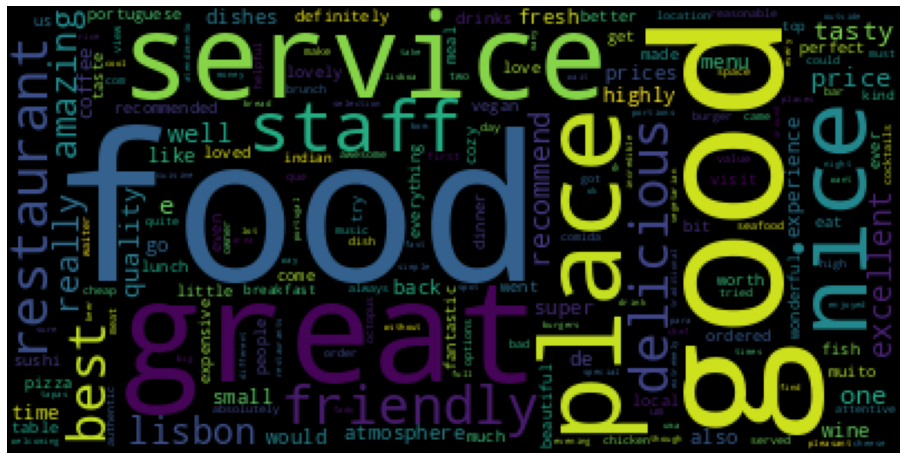

In [237]:
make_word_cloud(token_list, stop_words=stop_words)

In [238]:
frequent_words(token_list, ngrams_number=1, number_top_words=15)

[('food', 19822),
 ('good', 14988),
 ('great', 11473),
 ('service', 10423),
 ('place', 9577),
 ('nice', 7467),
 ('staff', 6630),
 ('friendly', 5873),
 ('restaurant', 5661),
 ('delicious', 5415),
 ('best', 5295),
 ('lisbon', 4912),
 ('amazing', 4731),
 ('really', 4267),
 ('excellent', 3931)]

In [239]:
frequent_words(token_list, ngrams_number=2, number_top_words=15)

[('good food', 1987),
 ('great food', 1655),
 ('food good', 1545),
 ('friendly staff', 1516),
 ('food great', 1244),
 ('good service', 1137),
 ('great service', 1119),
 ('delicious food', 1021),
 ('one best', 969),
 ('highly recommend', 894),
 ('really good', 886),
 ('nice place', 861),
 ('service good', 797),
 ('amazing food', 774),
 ('great place', 745)]

In [240]:
frequent_words(token_list, ngrams_number=3, number_top_words=15)

[('food great service', 305),
 ('food good service', 263),
 ('great food great', 253),
 ('good food good', 233),
 ('food friendly staff', 202),
 ('service good food', 186),
 ('good value money', 171),
 ('service great food', 152),
 ('definitely come back', 151),
 ('food excellent service', 151),
 ('good service good', 138),
 ('pastel de nata', 138),
 ('friendly staff good', 135),
 ('food really good', 130),
 ('good food nice', 126)]

In [171]:
!pip install shap

In [247]:
import sklearn.metrics as metrics

reviews_model_df = en_reviews_model_df.sample(frac = 1)
X_train, X_test, y_train, y_test = train_test_split(reviews_model_df['clean_comment'], reviews_model_df['good_bad_review'], random_state=42)


# create bag-of-words with weights using tfid vectoriser
# strip accents and remove stop words during vectorisation
tf=TfidfVectorizer(strip_accents = 'ascii', ngram_range=(1, 1))

# transform and fit the training set with vectoriser
X_train_tf = tf.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tf.transform(X_test)


# create logistic regression model
logreg = LogisticRegression(verbose=0, random_state=42, penalty='l2', solver='newton-cg', C=10)
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test, pred, average='weighted')

0.9147814420582407

In [252]:
# importing SHAP
import shap

# sampling data from the training and test set to reduce time-taken
X_train_sample = shap.sample(X_train_tf, 40)
X_test_sample = shap.sample(X_test_tf, 8)

# creating the KernelExplainer using the logistic regression model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer 
shap_vals = SHAP_explainer.shap_values(X_test_sample)

# converting the test samples to a dataframe 
# this is necessary for non-tabular data in order for the visualisations 
# to include feature value
colour_test = pd.DataFrame(X_test_sample.todense())

  0%|          | 0/8 [00:00<?, ?it/s]

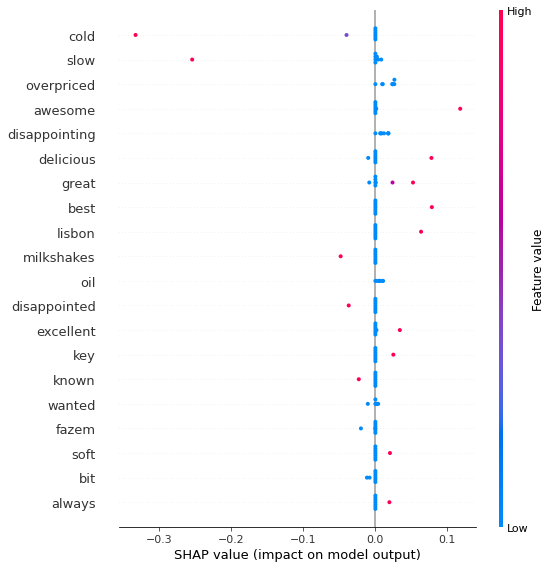

In [253]:
shap.summary_plot(shap_vals, colour_test, feature_names=tf.get_feature_names())